In [421]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime, date

In [511]:
# Loading data

df = pd.read_parquet("./data/movies.parquet")

# EDA

First of all we take a look at our gathered data, what kind of columns do we have and how many movies we managed to gather.

In [512]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1620 entries, 0 to 179
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          1620 non-null   object
 1   rating         1620 non-null   object
 2   release_date   1620 non-null   object
 3   description    1620 non-null   object
 4   genre          1620 non-null   object
 5   critics_score  1620 non-null   object
 6   top_actors     1620 non-null   object
 7   producer       1620 non-null   object
dtypes: object(8)
memory usage: 113.9+ KB


In [513]:
df.head()

,title,rating,release_date,description,genre,critics_score,top_actors,producer
0,Back to the Wharf,,"Jan 17, 2023",An escaped convict who was serving time for ne...,"[Drama,, Romance]",75,"[Zhang Yu, Jia Song, Wang Yanhui, Chen Jin, En...","Dun He, \n \n ..."
1,High Expectations,96,"Apr 7, 2022",Jack Davis (Taylor Gray) finds himself adrift ...,[Drama],,"[Kelsey Grammer, Ally Brooke, Taylor Gray, Bri...","Christopher D. White, \n ..."
2,Alkhallat+,,"Jan 19, 2023",An anthology of social deception and trickery ...,[Drama],,"[Fahad Albutairi, Ismail Alhassan, Sohayb Godu...",Fahad Alammari
3,Blaze,,"Jan 20, 2023","After accidentally witnessing a violent crime,...","[Crime,, Drama]",93,"[Simon Baker, Yael Stone, Josh Lawson, Julia S...",Samantha Jennings
4,Mission Majnu,58,"Jan 20, 2023","Set in the 1970s, an undercover Indian spy tak...","[Action,, Drama,, Mystery, &, thriller]",,"[Sidharth Malhotra, Rashmika Mandanna, Kumud M...",Shantanu Bagchi


### Data Cleaning

Then we clean our data. First of all we drop the movies which have not yet been rated. After that we drop all the duplicated movies, since data was collected by genre and a lot of movies can have a few genres at once.

In [514]:
df['rating'].replace('', np.nan, inplace=True)
df['critics_score'].replace('', np.nan, inplace=True)
df.dropna(subset='rating', inplace=True)
df.dropna(subset='critics_score', inplace=True)
df.drop_duplicates(subset='title', inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          578 non-null    object
 1   rating         578 non-null    object
 2   release_date   578 non-null    object
 3   description    578 non-null    object
 4   genre          578 non-null    object
 5   critics_score  578 non-null    object
 6   top_actors     578 non-null    object
 7   producer       578 non-null    object
dtypes: object(8)
memory usage: 36.2+ KB


In the sampled df above we were able to see, that producers column has some unwanted elements such as '\n' or whitespaces. Here we clean them all:

In [515]:
df['producer'] = df['producer'].str.split('\n').str.join('')
df['producer'] = df['producer'].str.replace('\n', '')
df['producer'] = df['producer'].str.replace('\n', '').str.rstrip(',')
df['producer'] = df['producer'].str.replace(',.*', '', regex=True)
df.head()

,title,rating,release_date,description,genre,critics_score,top_actors,producer
0,The Pale Blue Eye,72,"Dec 23, 2022","West Point, 1830. In the early hours of a gray...","[Mystery, &, thriller,, Drama]",62,"[Christian Bale, Harry Melling, Gillian Anders...",Scott Cooper
1,The Fabelmans,82,"Nov 23, 2022",Young Sammy Fabelman falls in love with movies...,[Drama],92,"[Michelle Williams, Paul Dano, Seth Rogen, Gab...",Steven Spielberg
2,Glass Onion: A Knives Out Mystery,93,"Nov 23, 2022",Benoit Blanc returns to peel back the layers i...,"[Mystery, &, thriller,, Comedy,, Drama]",92,"[Daniel Craig, Ed Norton, Dave Bautista, Kate ...",Rian Johnson
3,Mars One,66,"Jan 5, 2023","The Martins family are optimistic dreamers, qu...","[Drama,, Lgbtq+]",97,"[Rejane Faria, Carlos Francisco, Camilla Damiã...",Gabriel Martins
4,Devotion,92,"Nov 23, 2022","Devotion, an aerial war epic based on the best...","[War,, History,, Drama,, Action]",81,"[Glen Powell, Jonathan Majors, Joe Jonas, Chri...",J.D. Dillard


When we checked the information about our dataframe we saw that all of the columns were of object type. Here we convert the ones which are numeric to int type:

In [516]:
df['rating'] = df['rating'].astype(int)
df['critics_score'] = df['critics_score'].astype(int)

### Features

Since we know that a lot of these movies are produced by smaller studios, we ha a lot of unique producers:

In [517]:
df['producer'].nunique()

452

Then I decided to check how many of those producers produced more than 3 movies and plot how many movies each of these producers have made.

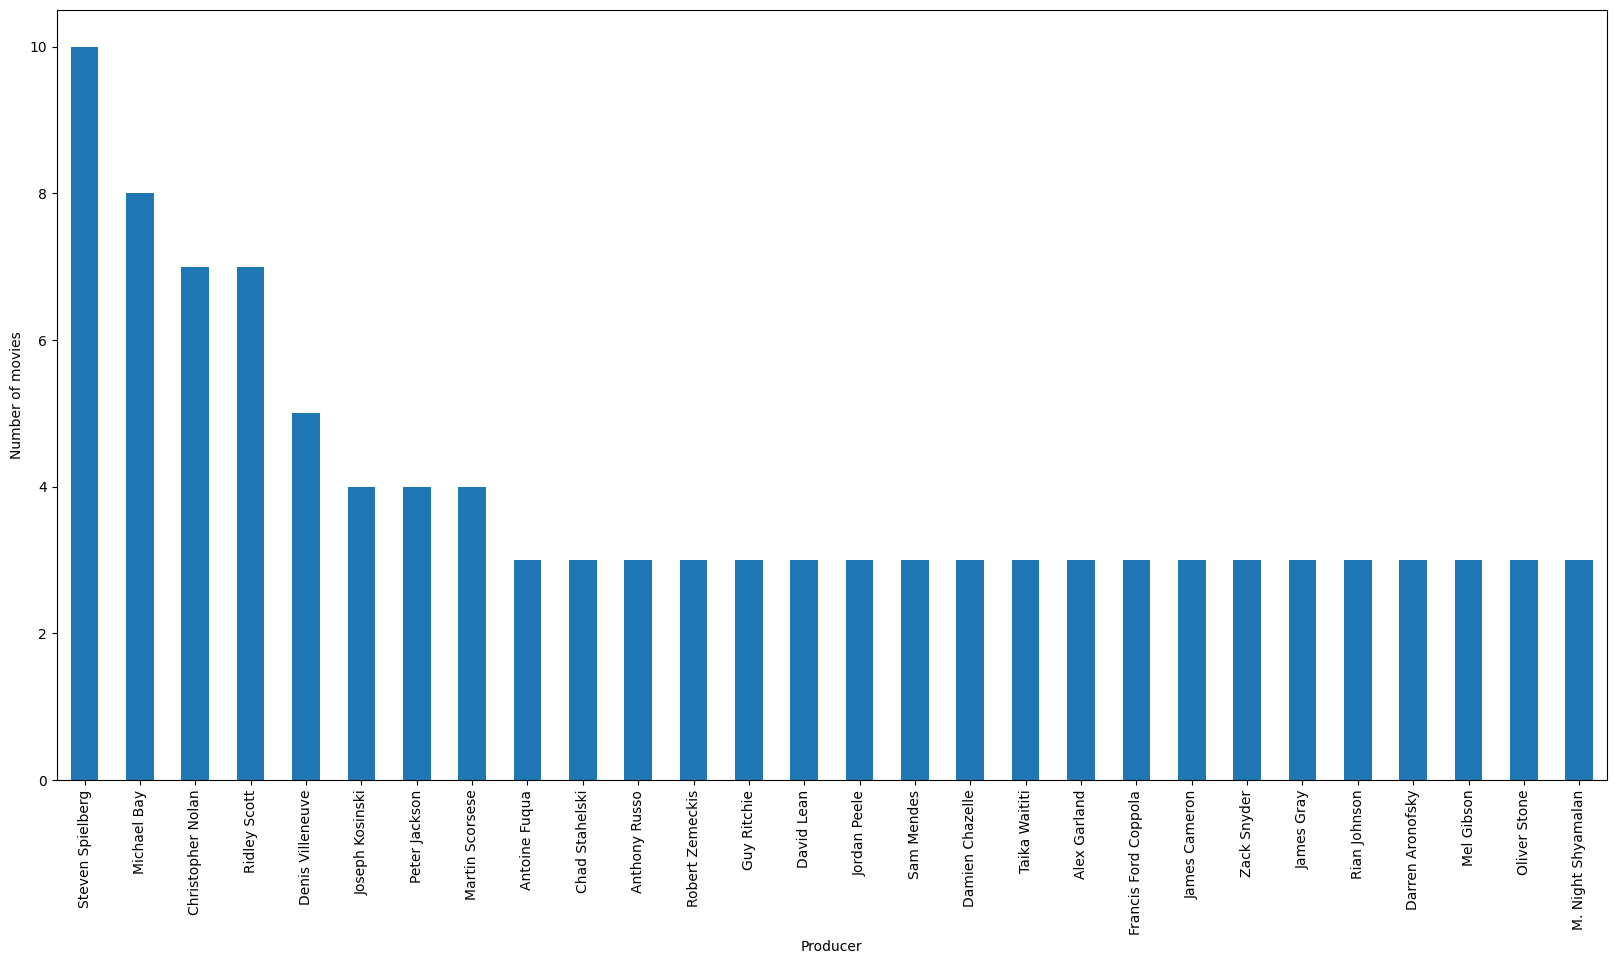

In [518]:
produced_movies = df['producer'].value_counts()

plt.figure(figsize=(20, 10))
produced_movies[produced_movies >= 3].plot(kind='bar')
plt.xlabel('Producer')
plt.ylabel('Number of movies')
plt.show()

From this bar chart I was able to see that four of producers stand out of others and decided to make each one of them as a feature, since if producer is well known and trusted he should be able to make better movies and by doing so he can influence the movie rating.

In [519]:
df['Steven Spielberg'] = df['producer'].apply(lambda x: 1 if 'Steven Spielberg' in x else 0)
df['Michael Bay'] = df['producer'].apply(lambda x: 1 if 'Michael Bay' in x else 0)
df['Christopher Nolan'] = df['producer'].apply(lambda x: 1 if 'Christopher Nolan' in x else 0)
df['Ridley Scott'] = df['producer'].apply(lambda x: 1 if 'Ridley Scott' in x else 0)

Then I added another feature, which shows how many movies were made by this producer in our dataset:

In [520]:
df['produced_movies'] = df['producer'].value_counts()[df['producer']].values

In our dataset movie can have a lot of genres. I decided that first genre in that list should be the main one and extracted it as a genre of a movie:

In [521]:
def extract_genres(val):
    st = ' '.join(val)
    return [i.strip() for i in st.split(',')][0]

extract_genres(df['genre'].values[0])

'Mystery & thriller'

In [522]:
movie_genre = []
for i in range(len(df['genre'])):
    movie_genre.append(extract_genres(df['genre'].values[i]))

df = df.assign(movie_genre=movie_genre)

Then I ploted how many of each genre movies we have:

<Figure size 2000x1000 with 0 Axes>

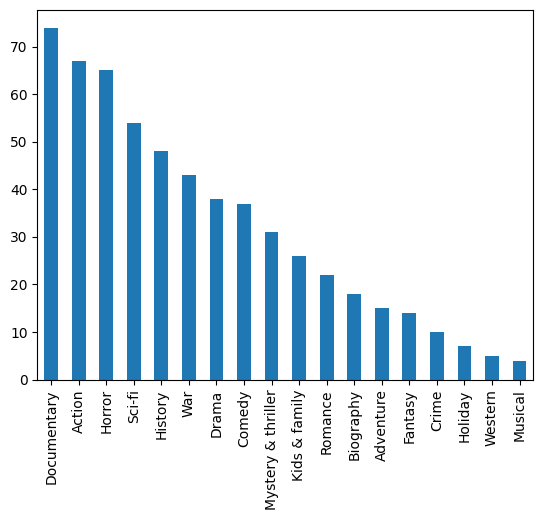

<Figure size 2000x1000 with 0 Axes>

In [523]:
counts = df['movie_genre'].value_counts()
counts.plot(kind='bar')
plt.figure(figsize=(20, 10))

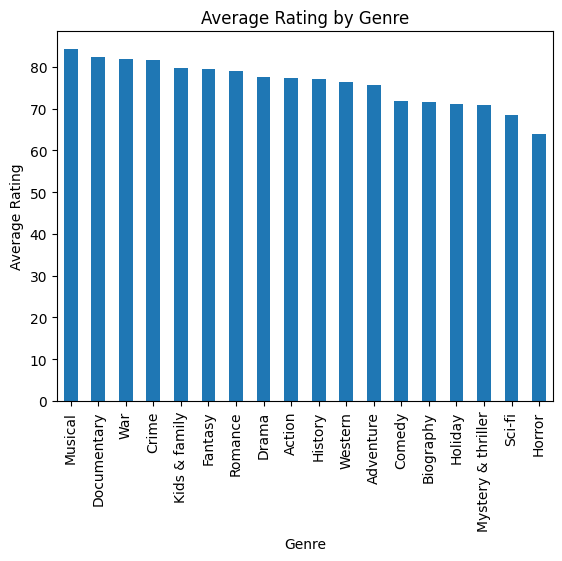

In [524]:
group_genres = df.groupby('movie_genre')['rating'].mean()
group_genres = group_genres.sort_values(ascending=False)
group_genres.plot(kind='bar')

plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.title("Average Rating by Genre")
plt.show()

From the graph above we can see that all genres have similar average ratings except Sci-Fi and Horror. Lets make these genres a feature, which would negatively impact our predictions.

In [525]:
df['Horror'] = df['movie_genre'].apply(lambda x: 1 if 'Horror' in x else 0)
df['Sci-fi'] = df['movie_genre'].apply(lambda x: 1 if 'Sci-fi' in x else 0)

Then I decided to take most popular actors and plot in how many movies they have appeared:

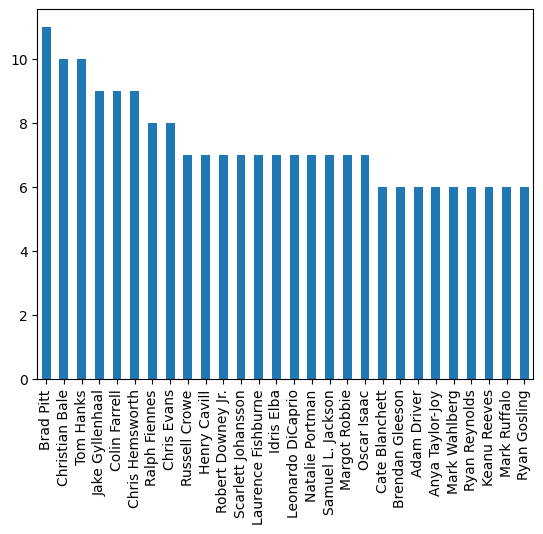

In [526]:
actor_popularity = df['top_actors'].explode().value_counts()
actor_popularity = actor_popularity[actor_popularity > 5]

actor_popularity.plot(kind='bar')
plt.show()

From this plot we can see that Brad Pitt, Chriastian Bale and Tom Hanks are most popular actors in our dataset, lets make them a feature and take a look at how they impact our rating later on:

In [527]:
df['Brad Pitt'] = df['top_actors'].apply(lambda x: 1 if 'Brad Pitt' in x else 0)
df['Christian Bale'] = df['top_actors'].apply(lambda x: 1 if 'Christian Bale' in x else 0)
df['Tom Hanks'] = df['top_actors'].apply(lambda x: 1 if 'Tom Hanks' in x else 0)

Then I decided to check how old a movie is and look at whats the correlation between its age and rating:

In [528]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%b %d, %Y')
df['release_month'] = df['release_date'].dt.month
df.reset_index(drop=True, inplace=True)

In [529]:
movie_age = []
for i in range(len(df['release_date'])):
    a = int(df['release_date'][i].strftime('%Y%m%d'))
    a = str(a)
    movie_age.append(2023 - int(a[:4]))

df = df.assign(movie_age=movie_age)

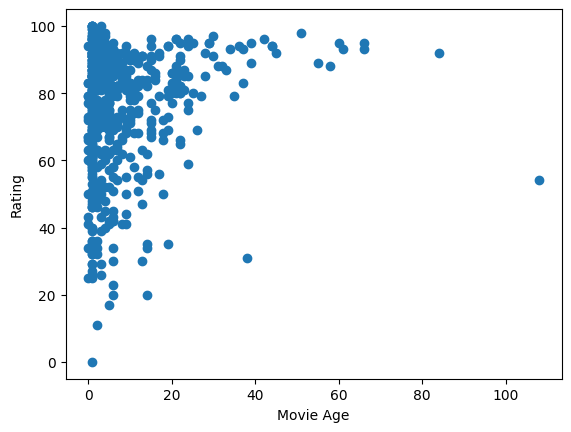

In [530]:
plt.scatter(df['movie_age'], df['rating'])
plt.xlabel('Movie Age')
plt.ylabel('Rating')
plt.show()

From this plot we can see that most of our movies are made in the last 10 years. Also we have way less older movies and those who are in our dataset generaly have higher rating. That should be the cause that streaming sites choose to only show good movies. Nevertheless we can say that older movies generaly have higher rating in our dataset.

C:\Users\Rokas\AppData\Local\Temp\ipykernel_2184\2491725.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


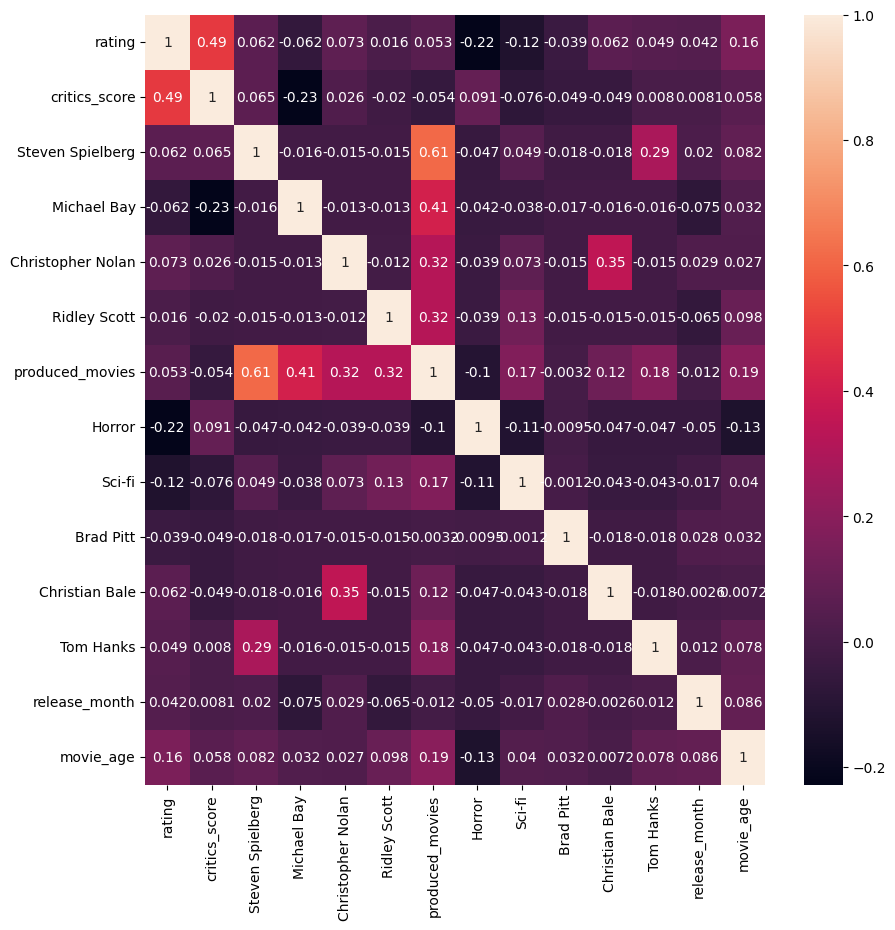

In [531]:
plt.figure(figsize=(10, 10))
corr = df.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

Produced heatmap shows us how our movie rating correlates with our features. Its not a huge surprise that critics score shows us the most, but it is still interesting that people agree with critics only half of the time. As mentioned before. It is important who produced our movie. For example Cristopher Nolan has a possitive correlation with movie rating while Michael Bay has a negative one. The same thing can be said about actors. Where Christian Bale is considered as a positive influence and Brad Pitt - negative. Both Horror and Sci-Fi genres are making negative impact on movie rating as said before. And as mentioned above, movie age positively influences our rating in our dataset.

c:\Users\Rokas\modeling\.venv\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


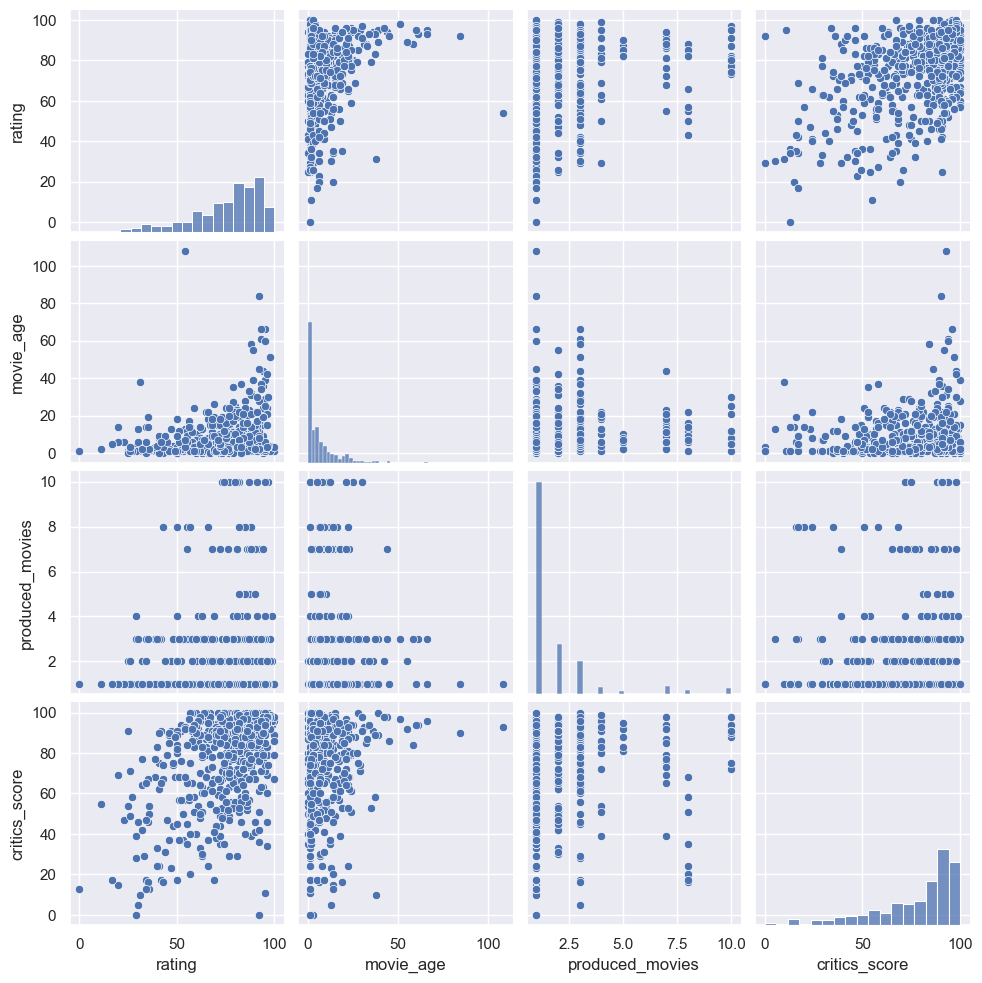

In [533]:
sns.set()
cols = ['rating', 'movie_age', 'produced_movies', 'critics_score']
sns.pairplot(df[cols], size = 2.5)
plt.show()

# Modelling

In [264]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error

from typing import Optional, Any, List

import pandas as pd

In [550]:
class BaselinePredictor:
    def __init__(self) -> None:
        self._avg_critics_rating = 0.0
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._avg_critics_rating = np.mean(y / X)
    
    def predict(self, X) -> np.ndarray:
        return 1.3 * self._avg_critics_rating

In [551]:
baseline = BaselinePredictor()
baseline.fit(df["critics_score"].values, df["rating"].values)

df[["critics_score", "rating"]].head(4)

C:\Users\Rokas\AppData\Local\Temp\ipykernel_2184\3761142026.py:6: RuntimeWarning: divide by zero encountered in divide
  self._avg_critics_rating = np.mean(y / X)


,critics_score,rating
0,62,72
1,92,82
2,92,93
3,97,66


In [552]:
print(baseline.predict(350))
print(baseline.predict(228))

inf
inf


In [539]:
df.columns

Index(['title', 'rating', 'release_date', 'description', 'genre',
       'critics_score', 'top_actors', 'producer', 'Steven Spielberg',
       'Michael Bay', 'Christopher Nolan', 'Ridley Scott', 'produced_movies',
       'movie_genre', 'Horror', 'Sci-fi', 'Brad Pitt', 'Christian Bale',
       'Tom Hanks', 'release_month', 'movie_age'],
      dtype='object')

### Preparing data for modelling

In [556]:
# Assigning X and y variables
X = df[['critics_score', 'producer',
        'Steven Spielberg', 'Michael Bay', 'Christopher Nolan', 'Ridley Scott', 'produced_movies',
        'movie_genre', 'Horror', 'Sci-fi', 'Brad Pitt', 'Christian Bale', 'Tom Hanks', 'release_month', 'movie_age']]
y = df['rating']

#Encoding data from string format to labels
for col in ['producer','movie_genre']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

C:\Users\Rokas\AppData\Local\Temp\ipykernel_2184\3802536907.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


Trying out a few different models:

In [557]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Absolute Error:  12.228160596630236
Mean Squared Error:  254.61853456745956


In [558]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Absolute Error:  16.28448275862069
Mean Squared Error:  494.30172413793105


In [559]:
model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Absolute Error:  12.962013847652889
Mean Squared Error:  290.6964311295297


From these three models we can say that the best performing model is Linear Regression with MAE = 12.23 and MSE = 254.62